In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_curve
from sklearn.metrics import auc,make_scorer
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import joblib
from sklearn.model_selection import GridSearchCV, learning_curve,RandomizedSearchCV,StratifiedKFold
import xgboost as xgb
from collections import Counter
import time


### Preprocessing



In [2]:
def preprocess(raw_data):
    
#     raw_data.iloc[:,   9:189] = raw_data.iloc[:, 9:189].div(raw_data['weight'], axis=0) #normalize all the V colums to weight
#     raw_data.iloc[:, 191:371] = raw_data.iloc[:, 191:371].div(raw_data['weight'], axis=0) #normalize all the V colums to weight
    
    mask1= raw_data['speed'].isin(['Not able to walk', 'no data', 'no valid trials', np.nan])
    mask2= raw_data['Speed'].isin(['Not able to trot', 'no data', 'no valid trials', np.nan])
    
#     raw_data.loc[~mask1, raw_data.columns[9:189]] = raw_data.loc[~mask1, raw_data.columns[9:189]].div(pd.to_numeric(raw_data.loc[~mask1,'speed']), axis=0) #normalize all the V colums to speed
#     raw_data.loc[~mask2, raw_data.columns[191:371]] = raw_data.loc[~mask2, raw_data.columns[191:371]].div(pd.to_numeric(raw_data.loc[~mask2,'Speed']), axis=0) #normalize all the V colums to speed
    
    raw_data['gait']=1 #change all string 'walk' to a number 1
    raw_data['Gait']=1 #change all string 'trot' to a number 1

    raw_data.loc[mask1, raw_data.columns[7:189]] = 0    #impute all the 'not able' column with 0
    raw_data.loc[mask2, raw_data.columns[189:371]] = 0  #impute all the 'not able' column with 0
    
    raw_data['speed'] = raw_data['speed'].astype(float)
    raw_data['Speed'] = raw_data['Speed'].astype(float)

    #drop object column, which is irrevelant colums to our modles
    raw_data.drop(['dob','forceplate_date'], axis=1, inplace=True)
    
    selected_columns = raw_data.loc[:, 'id':'speed'].join(raw_data.loc[:, 'V1_LF':'STD_V14_RH']).join(raw_data.loc[:, 'Gait':'Speed']).join(raw_data.loc[:, 'V1_LF_trot':'STD_V14_RH_trot'])
    selected_columns.to_csv('trash/tt_selectied_columns.csv')
    return selected_columns
#     return raw_data

In [3]:
def only_trot(data_train):
    drop_start_pos = data_train.columns.get_loc('gait')
    drop_end_pos = data_train.columns.get_loc('Gait')
    trot_train = data_train.drop(data_train.columns[drop_start_pos:drop_end_pos], axis=1)
    return trot_train

def only_walk(data_train):
    drop_start_pos = data_train.columns.get_loc('Gait')
    walk_train = data_train.drop(data_train.columns[drop_start_pos:], axis=1)
    return walk_train

def outlier_processing(data_train):
    selected_columns = data_train.loc[:, 'age':]
    rows_to_drop = selected_columns.apply(lambda row: (row > outlier_threshold).any(), axis=1)
    print(data_train.loc[rows_to_drop,'id'])
    filtered_data = data_train.loc[~rows_to_drop]
    
    drop_index = np.where(rows_to_drop)[0]
    return drop_index, filtered_data

def drop_missing_value(data_train):
    missing_counts = data_train.isna().sum(axis=1)
    # Drop rows with more than 4 missing values
    drop_index = missing_counts[missing_counts > drop_missing_value_threshold].index
    filtered_data = data_train.drop(drop_index)
    return drop_index, filtered_data

### Feature Engineering

In [4]:
def add_area(augmented_data):
    area_four_leg = pd.DataFrame()
    max_four_leg = pd.DataFrame()
    
    for loc in ['LF','RF','LH','RH']:
        column_list = []
        for i in range(11,15):
            if i==14:
                column_list.append('Mean_V'+str(i)+'_'+loc)
            else:
                column_list.append('V'+str(i)+'_'+loc)
        df = augmented_data[column_list]
        df['V10_'+loc]=0
        df['V15_'+loc]=0
        column_list = ['V10_'+loc]+ column_list +['V15_'+loc]
        df['area_'+loc]= 0
        for i in range(5):
            sub_area = (df[column_list[i]]+df[column_list[i+1]])*1/2 # Trapezoid Area Formula
            df['area_'+loc] += sub_area

        augmented_data = augmented_data.join(df['area_'+loc])
        
    return augmented_data

In [5]:
def add_peak(augmented_data):
    area_four_leg = pd.DataFrame()
    max_four_leg = pd.DataFrame()
    
    for loc in ['LF','RF','LH','RH']:
        column_list = []
        for i in range(11,15):
            if i==14:
                column_list.append('Mean_V'+str(i)+'_'+loc)
            else:
                column_list.append('V'+str(i)+'_'+loc)
        df = augmented_data[column_list]
        df['V10_'+loc]=0
        df['V15_'+loc]=0
        column_list = ['V10_'+loc]+ column_list +['V15_'+loc]

        df['max_'+loc] = df[column_list].max(axis=1)
        augmented_data = augmented_data.join(df['max_'+loc])
        
    return augmented_data

### Generate final data

In [6]:
outlier_process_flag = False
outlier_threshold = 10000 # should be 150, if after V is normalizied with weight and speed. 10000, if V is not normalized
drop_missing_value_flag = False
drop_missing_value_threshold = 14*8-1
drop_bio_info_flag = False
add_feature_area = False
add_feature_peak = False

In [7]:
def augmented_trainset(data_train):
    trot_train = only_trot(data_train)
    walk_train = only_walk(data_train)

    trot_train.columns=walk_train.columns
    train_augmented = pd.concat([walk_train, trot_train])
    train_augmented = train_augmented.reset_index(drop=True) 
    
    if add_feature_area:
        train_augmented = add_area(train_augmented)
    if add_feature_peak:
        train_augmented = add_peak(train_augmented)
        
    if outlier_process_flag:
        _,train_final = outlier_processing(train_augmented)
    else:
        train_final = train_augmented
    
    if drop_missing_value_flag:
        _,train_final = drop_missing_value(train_final)
        
    if drop_bio_info_flag:
        X_train = train_final.drop([loca,'id','weight','age','gait','speed','gender'], axis=1)
    else:
        X_train = train_final.drop([loca,'id'], axis=1)
    y_train = train_final[loca]
    
    return X_train, y_train

In [8]:
def get_val_data(data_val):
    val_trot = only_trot(data_val)
    val_walk = only_walk(data_val)
    val_trot.columns=val_walk.columns
    
    #initialize all weights as 1
    lines = data_val.shape[0]
    val_weights = np.ones((lines, 2))
    
    if add_feature_area:
        val_trot = add_area(val_trot)
        val_walk = add_area(val_walk)
    if add_feature_peak:
        val_trot = add_peak(val_trot)
        val_walk = add_peak(val_walk)

    if outlier_process_flag:
        drop_index_walk,_= outlier_processing(val_walk)
        drop_index_trot,_= outlier_processing(val_trot)
        for i in drop_index_walk:
            val_weights[i,0]=0
        for j in drop_index_trot:
            val_weights[j,1]=0
    if drop_missing_value_flag:
        drop_index_walk,_= drop_missing_value(val_walk)
        drop_index_trot,_= drop_missing_value(val_trot)
        for i in drop_index_walk:
            val_weights[i,0]=0
        for j in drop_index_trot:
            val_weights[j,1]=0

        
    if drop_bio_info_flag:
        X_trot_val = val_trot.drop([loca,'id','weight','age','Gait','Speed','gender'], axis=1)
        X_walk_val = val_walk.drop([loca,'id','weight','age','gait','speed','gender'], axis=1)
    else:
        X_trot_val = val_trot.drop([loca,'id'], axis=1)
        X_walk_val = val_walk.drop([loca,'id'], axis=1)
    y_val = val_walk[loca]
    
    
    
    return val_weights, X_walk_val, X_trot_val, y_val

### Train

In [9]:
def plot_PR_curve(y_label, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_label, y_prob)
    
    plt.figure(figsize=(15, 15))
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    for i, threshold in enumerate(thresholds):
        plt.annotate(f'{threshold:.4f}', (recall[i], precision[i]), textcoords='offset points',fontsize=10,rotation=45,  xytext=(0, 0), ha='left',color='green')
    plt.grid(True)
    plt.show()
def cal_prAUC(y_label, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_label, y_prob)
    pr_auc_score = auc(recall, precision)
    return pr_auc_score

In [10]:
def combine_predcict(model,data_val):
    val_weights, X_walk_val, X_trot_val, y_val = get_val_data(data_val)
    X_walk_val.to_csv('trash/ttt_X_walk_val.csv')
    X_trot_val.to_csv('trash/ttt_X_trot_val.csv')
    y_val.to_csv('trash/ttt_y_val.csv')
#     print(X_walk_val)
    X_trot_val.columns = X_walk_val.columns
    
    y_walk_pred = model.predict_proba(X_walk_val)[:, 1]
    y_trot_pred = model.predict_proba(X_trot_val)[:, 1]
    
    y_pred_prob = (y_walk_pred * val_weights[:, 0] + y_trot_pred * val_weights[:, 1]) / (val_weights[:, 0] + val_weights[:, 1])
    y_pred_prob = np.nan_to_num(y_pred_prob)

    pr_auc = cal_prAUC(y_val, y_pred_prob)
    
    return pr_auc,y_pred_prob,y_val

In [11]:
def combine_predcict_2(model,data_val):
    val_weights, X_walk_val, X_trot_val, y_val = get_val_data(data_val)
    X_walk_val.to_csv('trash/ttt_X_walk_val.csv')
    y_val.to_csv('trash/ttt_y_val.csv')
    X_trot_val.columns = X_walk_val.columns
    
    d_walk_val = xgb.DMatrix(X_walk_val)
    d_trot_val = xgb.DMatrix(X_trot_val)
    
    y_walk_pred = model.predict(d_walk_val)
    y_trot_pred = model.predict(d_trot_val)
    
    y_pred_prob = (y_walk_pred * val_weights[:, 0] + y_trot_pred * val_weights[:, 1]) / (val_weights[:, 0] + val_weights[:, 1])
    y_pred_prob = np.nan_to_num(y_pred_prob)
    
    pr_auc = cal_prAUC(y_val, y_pred_prob)
    
    return pr_auc,y_pred_prob, y_val

In [12]:
def plot_learning_curve_boost(params, dtrain, num_rounds, metric, cv_folds):
    eval_history = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=cv_folds,
                           metrics=metric, stratified=True, verbose_eval=False)
    
    plt.plot(eval_history['train-' + metric + '-mean'], label="Training")
    plt.plot(eval_history['test-' + metric + '-mean'], label="Validation")
    plt.xlabel("Boosting Round")
    plt.ylabel(metric.upper())
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

In [13]:

def plot_learning_curve_examples(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot learning curve for an estimator.
    
    estimator: the model 
    X, y: training data and target variable
    cv: cross-validation method, integer or an iterator
    n_jobs: number of jobs for parallel computation. None means 1. -1 means using all available cores.
    train_sizes: sizes of the chunks of data used to draw each point in the curve.
    """
    
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt



## Prepare data

In [14]:
import warnings
warnings.filterwarnings('ignore')

loca='LF'
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
data_train = preprocess(raw_data_train)

# print(data_train)
X_train,y_train = augmented_trainset(data_train)
# X_train.to_csv('trash/tt_brandnewV2.csv')

counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print(estimate)

dtrain = xgb.DMatrix(X_train, label=y_train)


FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/LF_train.csv'

## Search best parameter set

In [966]:
cv_folds=8
# Parameter grids
max_depth_options = [1,2,3,4,5,6,8]
learning_rate_options = [0.1,0.3,0.6]
scale_pos_weight_options = [1,2,3,4,5,6,7]

# gamma_options= [1,3,5]
# reg_alpha_options = [0.1,1,4]
    
best_score = 0
best_params = None
progress=0
# Loop over parameter combinations


for max_depth in max_depth_options:
    for learning_rate in learning_rate_options:
        for scale_pos_weight in scale_pos_weight_options:
#             for gamma in gamma_options:
#                 for reg_alpha in reg_alpha_options:
            progress+=1
            if progress%10==0:
                print(f'Progress:{progress}/{7*3*7}')
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'aucpr',  # set AUCPR as the evaluation metric
                'scale_pos_weight': scale_pos_weight,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
#                 'gamma':gamma,
#                 'reg_alpha':reg_alpha,
                'n_jobs':5
            }

            # Running cross-validation
            cv_results = xgb.cv(params, dtrain, num_boost_round=700, nfold=cv_folds, 
                                metrics="aucpr", stratified=True, early_stopping_rounds=200)

            # Finding the best parameters
            mean_aucpr = cv_results['test-aucpr-mean'].max()
            boost_rounds = cv_results['test-aucpr-mean'].argmax()


            if mean_aucpr > best_score:
                best_score = mean_aucpr
                best_params = (max_depth, learning_rate, scale_pos_weight,boost_rounds,gamma, reg_alpha)
                print("Current Best params: {}, {}, {},  round:{}, AUCPR: {}".format(best_params[0], best_params[1], best_params[2], best_params[3], best_score))


print("Final:  Best params: {}, {}, {}, round:{}, AUCPR: {}".format(best_params[0], best_params[1], best_params[2], best_params[3], best_score))


Current Best params: 1, 0.1, 1,  round:46, AUCPR: 0.6776511538505836
Progress:10/147
Current Best params: 1, 0.6, 1,  round:7, AUCPR: 0.6941617153625241
Current Best params: 1, 0.6, 2,  round:7, AUCPR: 0.7385631108406872
Progress:20/147
Progress:30/147
Progress:40/147
Progress:50/147
Progress:60/147
Progress:70/147
Progress:80/147
Progress:90/147
Progress:100/147
Progress:110/147
Progress:120/147
Progress:130/147
Progress:140/147
Final:  Best params: 1, 0.6, 2, round:7, AUCPR: 0.7385631108406872


### Best parameter sets obtained from grid search with different CV folds，we choose different parameter set for different leg according to the learning curve and AUCPR, parameters in bold font is the parameters chosen

CV:5

LF:
Final:  Best params: 1, 0.6, 2, round:7, AUCPR: 0.5910816575077764

LH:
Final:  Best params: 1, 0.6, 7, round:193, AUCPR: 0.9151397048105414

RF:
Final:  Best params: 1, 0.1, 2, round:15, AUCPR: 0.650404678844642
            
RH:
Final:  Best params: 2, 0.6, 1, round:194, AUCPR: 0.8937267890117061

CV:7

LF:
Final:  Best params: 1, 0.6, 1, round:5, AUCPR: 0.7490808156915426
                
LH:
Final:  Best params: 5, 0.6, 7, round:8, AUCPR: 0.9350864021554214
            
RF:
Final:  Best params: 1, 0.1, 3, round:18, AUCPR: 0.6367438328834297
                
RH:
Final:  Best params: 1, 0.6, 4, round:138, AUCPR: 0.9081887847252806

CV:8
    
#### LF: Final:  Best params: 1, 0.6, 2, round:7, AUCPR: 0.7385631108406872
                
LH:
Current Best params: 2, 0.3, 7, round:99, AUCPR: 0.9306644352357374
                
RF:
Final:  Best params: 1, 0.3, 2, round:8, AUCPR: 0.6992048414254064
                
#### RH: Final:  Best params: 1, 0.6, 4, round:131, AUCPR: 0.9073049643496356             


CV:10
    
LF: 
Final:  Best params: 1, 0.6, 2, round:5, AUCPR: 0.7059324010094267
                
LH:
Final:  Best params: 5, 0.3, 7, round:234, AUCPR: 0.9230505172266744
                
RF:
Final:  Best params: 1, 0.6, 6, round:26, AUCPR: 0.6852269020342815
                
RH:
Final:  Best params: 6, 0.3, 1, round:334, AUCPR: 0.9177905742757655
                


CV:13

LF:
Final:  Best params: 1, 0.6, 2, round:5, AUCPR: 0.7082959279934815

#### LH: Final:  Best params: 3, 0.6, 5, round:23, AUCPR: 0.944619588666098
                
#### RF: Final:  Best params: 1, 0.3, 1, round:14, AUCPR: 0.703614944648044
            
RH:
Final:  Best params: 3, 0.3, 3, round:498, AUCPR: 0.9228211285066745

CV:15
    
LF:
Final:  Best params: 1, 0.6, 3, round:8, AUCPR: 0.7647136057344495

LH:
Final:  Best params: 4, 0.6, 6, round:18, AUCPR: 0.9558726444580431
                
RF:
Final:  Best params: 1, 0.6, 3, round:23, AUCPR: 0.7287230282795155
                
RH:
Final:  Best params: 5, 0.6, 3, round:198, AUCPR: 0.9155968759559393

## Check the learning curve(AUC against boost round and against examples)

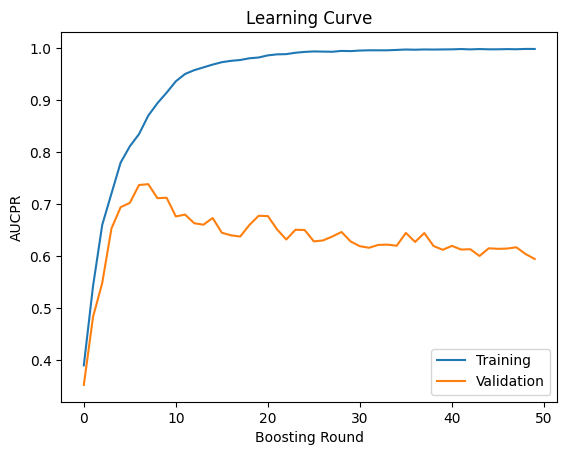

In [969]:
## we need manually set the best parameters to examine here 
cv_folds=8
best_model_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',

    'max_depth': 1,
    'learning_rate': 0.6,
    'scale_pos_weight': 2,
#     'gamma':1,
#     'reg_alpha':0.01
    
}
best_iterations=7
total_iterations=50
plot_learning_curve_boost(best_model_params, dtrain, total_iterations, "aucpr",cv_folds)

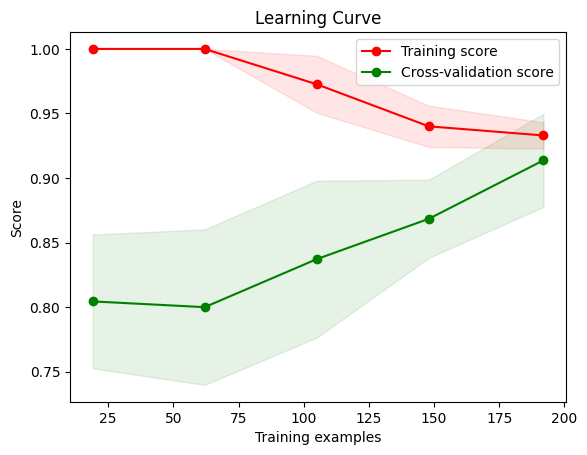

In [970]:
estimator = xgb.XGBClassifier(**best_model_params, n_estimators=best_iterations)
plot_learning_curve_examples(estimator, X_train, y_train, cv=cv_folds)
plt.show()

## use the best parameters to train the final model on all training data(No CV now)

In [971]:
## we need manually set the best parameters to use here 
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'max_depth': 1,
    'learning_rate': 0.6,
    'scale_pos_weight': 2,
#     'gamma':8,
#     'reg_alpha':0.3
}
iterations=7

In [972]:
final_model = xgb.train(params=params, 
                        dtrain=dtrain, 
                        num_boost_round= iterations)

## calculate the AUC on train set and find the best threshold on train set

In [973]:
y_pred_train = final_model.predict(dtrain)
cal_prAUC(y_train, y_pred_train)

0.813289679472772

In [974]:
pr_auc_train,y_pred_prob_train,y_train_combine = combine_predcict_2(final_model,data_train)
print(pr_auc_train)

0.8679231416731417


0.8679231416731417


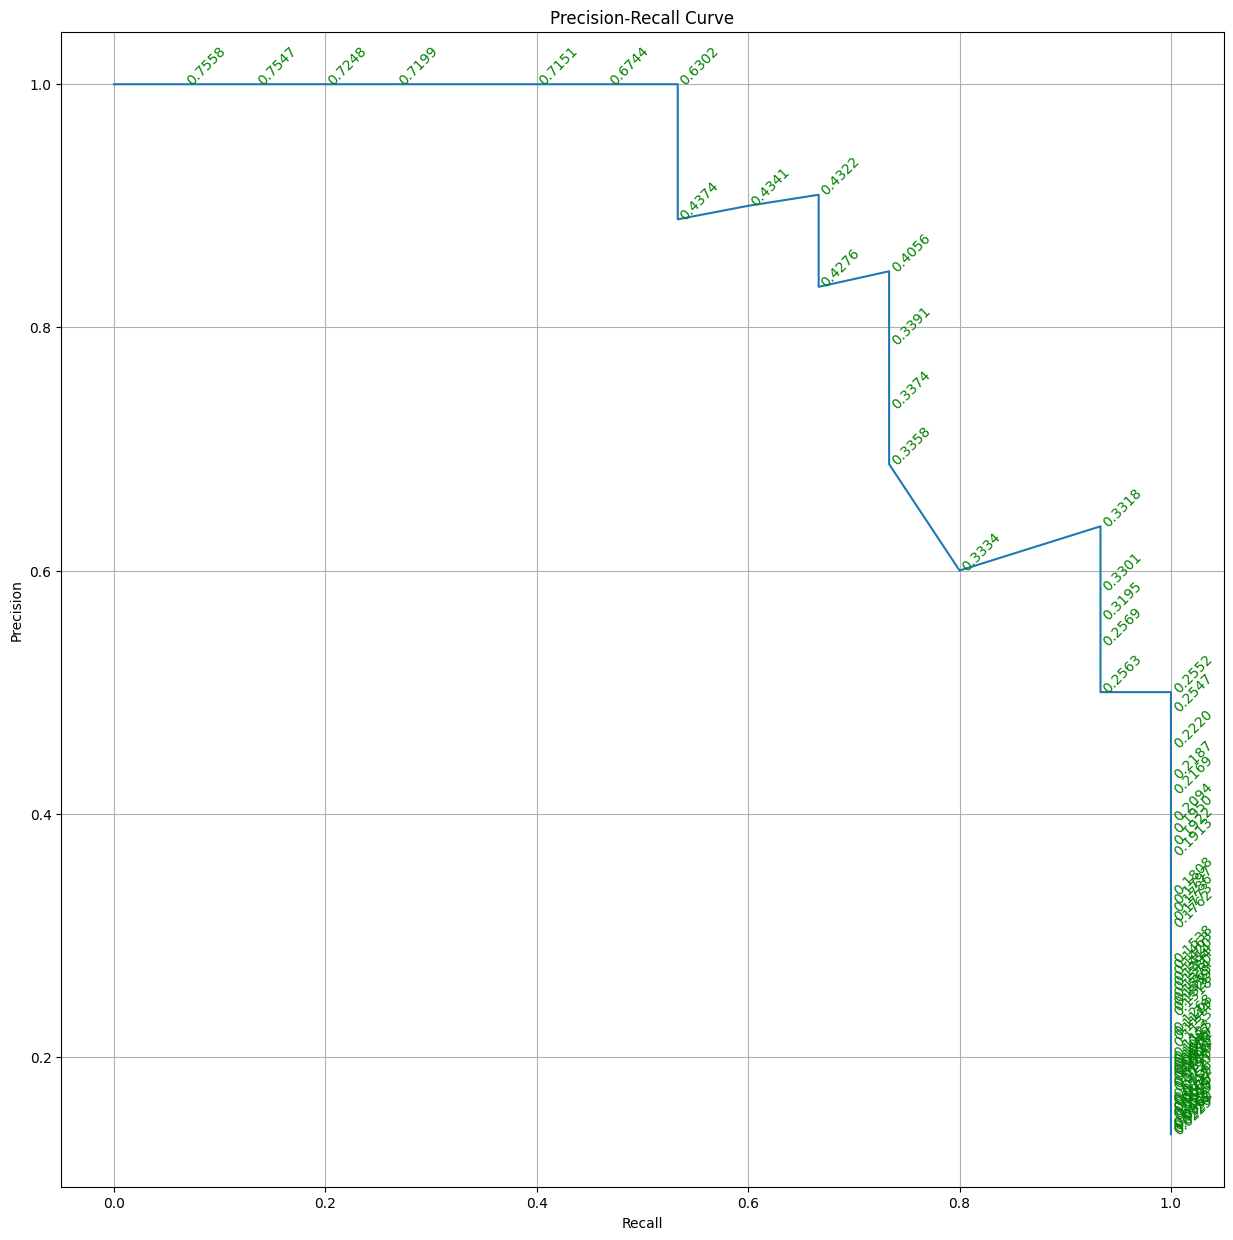

0.0
f1: 0.24000000000000002
0.023
f1: 0.24193548387096775
0.033
f1: 0.2459016393442623
0.036000000000000004
f1: 0.24793388429752064
0.037
f1: 0.25
0.049
f1: 0.25862068965517243
0.057
f1: 0.2608695652173913
0.065
f1: 0.2631578947368421
0.066
f1: 0.2678571428571429
0.067
f1: 0.2702702702702703
0.068
f1: 0.27522935779816515
0.07
f1: 0.27777777777777773
0.07200000000000001
f1: 0.2803738317757009
0.075
f1: 0.2857142857142857
0.076
f1: 0.29411764705882354
0.079
f1: 0.297029702970297
0.08
f1: 0.3
0.088
f1: 0.30612244897959184
0.09
f1: 0.30927835051546393
0.091
f1: 0.3125
0.096
f1: 0.3157894736842105
0.098
f1: 0.3191489361702127
0.10200000000000001
f1: 0.32258064516129037
0.10400000000000001
f1: 0.32608695652173914
0.105
f1: 0.32967032967032966
0.109
f1: 0.33333333333333337
0.113
f1: 0.3448275862068966
0.114
f1: 0.35294117647058826
0.115
f1: 0.3571428571428571
0.11800000000000001
f1: 0.36144578313253006
0.127
f1: 0.379746835443038
0.132
f1: 0.3846153846153846
0.133
f1: 0.38961038961038963
0.13

In [975]:
best_f1=0
best_threshold=0
print(cal_prAUC(y_train_combine, y_pred_prob_train))
plot_PR_curve(y_train_combine, y_pred_prob_train)
for threshold in np.arange(0,0.999,0.001):
    y_pred  = (y_pred_prob_train > threshold).astype(int)

    f1_XGBoost = f1_score(y_train_combine, y_pred)
    if f1_XGBoost>best_f1:
        print(threshold)
        print(f"f1: {f1_XGBoost}")
        best_f1=f1_XGBoost
        best_threshold= threshold
print(f'AUC: {cal_prAUC(y_train_combine, y_pred_prob_train)}')

In [976]:
# best_threshold=0.5

## calculate the prediction on test data and save preditcion file

In [977]:
raw_data_test = pd.read_csv('predict/'+loca+'_test.csv')

data_test = preprocess(raw_data_test)

test_weights, X_walk_test, X_trot_test, _ = get_val_data(data_test)
X_trot_test.columns = X_walk_test.columns

d_walk_test = xgb.DMatrix(X_walk_test)
d_trot_test = xgb.DMatrix(X_trot_test)

y_walk_test_pred = final_model.predict(d_walk_test)
y_trot_test_pred = final_model.predict(d_trot_test)

y_pred_test_prob = (y_walk_test_pred * test_weights[:, 0] + y_trot_test_pred * test_weights[:, 1]) / (test_weights[:, 0] + test_weights[:, 1])
y_pred_test_prob = np.nan_to_num(y_pred_test_prob)

print(f'We choose {best_threshold} as threshold here')
y_test_pred  = (y_pred_test_prob > best_threshold).astype(int)

raw_data_test[loca]=y_test_pred
output=raw_data_test[['id',loca]]
output.to_csv(f"predict/predicted_{loca}_test_labels.csv", index=False)

We choose 0.34 as threshold here
